In [8]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec

In [9]:
import json

In [10]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [11]:
figdir = '../../Figures/Components'

In [12]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

Benchmark using gene set scoring in python.

In [2]:
MP_list = pd.read_json('../../../Data/Misc/Gavish_2023_Nat/MP_list.json')

In [6]:
with open('../../../Data/Misc/Gavish_2023_Nat/MP_list.json', "r") as json_file:
    MP_list = json.load(json_file)


In [13]:
MP_list.keys()

dict_keys(['Cancer', 'Endothelial', 'Epithelial', 'Fibroblasts', 'Macrophages', 'CD4_T_cells', 'CD8_T_cells', 'B_cells'])

In [14]:
MP_list['CD4_T_cells'].keys()

dict_keys(['MP1 T_reg', 'MP2 Naive1', 'MP3 Cell_cycle', 'MP4 Cytotoxic', 'MP5 Dysfunction', 'MP6 Interferon', 'MP7 Glycolysis/MYC', 'MP8 Naive2', 'MP9 Unassigned', 'MP10 Stress/HSP'])

In [16]:
MP_list['CD8_T_cells'].keys()

dict_keys(['MP1 Cytotoxic', 'MP2 Cell_cycle', 'MP3 Memory/Naive1', 'MP4 Interferon', 'MP5 Unassigned1', 'MP6 Naive2', 'MP7 Glycolysis/MYC', 'MP8 Chromatin', 'MP9 Unassigned2', 'MP10 Heat_shock', 'MP11 Naive3', 'MP12 Dysfunction'])

In [17]:
MP_list['CD8_T_cells']

{'MP1 Cytotoxic': ['GZMB',
  'GZMH',
  'PRF1',
  'CCL4',
  'GNLY',
  'GZMA',
  'ALOX5AP',
  'CCL4L2',
  'KLRD1',
  'CD63',
  'HOPX',
  'NKG7',
  'CST7',
  'GZMK',
  'CCL3',
  'APOBEC3G',
  'IFNG',
  'CXCR6',
  'HLA-DRA',
  'CMC1',
  'HLA-DRB1',
  'TIGIT',
  'CXCL13',
  'LAG3',
  'CTSW',
  'LGALS1',
  'RGS1',
  'HLA-DPA1',
  'KLRB1',
  'CD27',
  'ITGB2',
  'DUSP2',
  'CTSD',
  'DUSP4',
  'HAVCR2',
  'SAMSN1',
  'ITM2C',
  'TRGC2',
  'ZNF683',
  'HLA-DPB1',
  'CAPG',
  'KLRG1',
  'RBPJ',
  'AC092580.4',
  'ITM2A',
  'CD7',
  'CKLF',
  'KLRC1',
  'RGS2',
  'ID2'],
 'MP2 Cell_cycle': ['STMN1',
  'TUBB',
  'TUBA1B',
  'HMGB2',
  'CKS1B',
  'NUSAP1',
  'PCNA',
  'TYMS',
  'DUT',
  'UBE2C',
  'HMGN2',
  'SMC4',
  'TOP2A',
  'HIST1H4C',
  'CDK1',
  'MKI67',
  'CENPF',
  'KIAA0101',
  'BIRC5',
  'CKS2',
  'PTTG1',
  'ZWINT',
  'MAD2L1',
  'RANBP1',
  'TK1',
  'MCM7',
  'CENPM',
  'RRM2',
  'SMC2',
  'DNAJC9',
  'TMPO',
  'RPA3',
  'TUBB4B',
  'CDKN3',
  'H2AFZ',
  'UBE2T',
  'AURKB',
  'TMEM106

In [23]:
T_gsets = {'CD8_'+k:v for k,v in MP_list['CD8_T_cells'].items()}
T_gsets.update({'CD4_'+k:v for k,v in MP_list['CD4_T_cells'].items()})

In [25]:
T_gsets

{'CD8_MP1 Cytotoxic': ['GZMB',
  'GZMH',
  'PRF1',
  'CCL4',
  'GNLY',
  'GZMA',
  'ALOX5AP',
  'CCL4L2',
  'KLRD1',
  'CD63',
  'HOPX',
  'NKG7',
  'CST7',
  'GZMK',
  'CCL3',
  'APOBEC3G',
  'IFNG',
  'CXCR6',
  'HLA-DRA',
  'CMC1',
  'HLA-DRB1',
  'TIGIT',
  'CXCL13',
  'LAG3',
  'CTSW',
  'LGALS1',
  'RGS1',
  'HLA-DPA1',
  'KLRB1',
  'CD27',
  'ITGB2',
  'DUSP2',
  'CTSD',
  'DUSP4',
  'HAVCR2',
  'SAMSN1',
  'ITM2C',
  'TRGC2',
  'ZNF683',
  'HLA-DPB1',
  'CAPG',
  'KLRG1',
  'RBPJ',
  'AC092580.4',
  'ITM2A',
  'CD7',
  'CKLF',
  'KLRC1',
  'RGS2',
  'ID2'],
 'CD8_MP2 Cell_cycle': ['STMN1',
  'TUBB',
  'TUBA1B',
  'HMGB2',
  'CKS1B',
  'NUSAP1',
  'PCNA',
  'TYMS',
  'DUT',
  'UBE2C',
  'HMGN2',
  'SMC4',
  'TOP2A',
  'HIST1H4C',
  'CDK1',
  'MKI67',
  'CENPF',
  'KIAA0101',
  'BIRC5',
  'CKS2',
  'PTTG1',
  'ZWINT',
  'MAD2L1',
  'RANBP1',
  'TK1',
  'MCM7',
  'CENPM',
  'RRM2',
  'SMC2',
  'DNAJC9',
  'TMPO',
  'RPA3',
  'TUBB4B',
  'CDKN3',
  'H2AFZ',
  'UBE2T',
  'AURKB',
  

In [26]:
T_gsets.keys()

dict_keys(['CD8_MP1 Cytotoxic', 'CD8_MP2 Cell_cycle', 'CD8_MP3 Memory/Naive1', 'CD8_MP4 Interferon', 'CD8_MP5 Unassigned1', 'CD8_MP6 Naive2', 'CD8_MP7 Glycolysis/MYC', 'CD8_MP8 Chromatin', 'CD8_MP9 Unassigned2', 'CD8_MP10 Heat_shock', 'CD8_MP11 Naive3', 'CD8_MP12 Dysfunction', 'CD4_MP1 T_reg', 'CD4_MP2 Naive1', 'CD4_MP3 Cell_cycle', 'CD4_MP4 Cytotoxic', 'CD4_MP5 Dysfunction', 'CD4_MP6 Interferon', 'CD4_MP7 Glycolysis/MYC', 'CD4_MP8 Naive2', 'CD4_MP9 Unassigned', 'CD4_MP10 Stress/HSP'])

In [27]:
dataset = 'Sparks'
adata = sc.read(params.loc[dataset, 'raw_counts_filt_fn'])
adata_RNA = adata[:, adata.var['feature_types'] == 'Gene Expression']

In [ ]:
adata.var

In [31]:
params.loc[dataset, 'raw_counts_filt_fn']

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/T_fromSeurat.FiltForcNMF.h5ad'

In [34]:
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)

sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [43]:
for gset, gene_list in T_gsets.items():
    # res = sc.tl.score_genes(adata_RNA, gene_list)
    print(gset)
    sc.tl.score_genes(adata_RNA, gene_list, score_name=gset)

CD8_MP1 Cytotoxic
CD8_MP2 Cell_cycle
CD8_MP3 Memory/Naive1
CD8_MP4 Interferon
CD8_MP5 Unassigned1
CD8_MP6 Naive2
CD8_MP7 Glycolysis/MYC
CD8_MP8 Chromatin
CD8_MP9 Unassigned2
CD8_MP10 Heat_shock
CD8_MP11 Naive3
CD8_MP12 Dysfunction
CD4_MP1 T_reg
CD4_MP2 Naive1
CD4_MP3 Cell_cycle
CD4_MP4 Cytotoxic
CD4_MP5 Dysfunction
CD4_MP6 Interferon
CD4_MP7 Glycolysis/MYC
CD4_MP8 Naive2
CD4_MP9 Unassigned
CD4_MP10 Stress/HSP


In [47]:
H = adata_RNA.obs[T_gsets.keys()].copy()

In [50]:
H.to_csv('../../../Data/PerDataset/Sparks2023/Gavish_ScanpyScore_Usage.tsv', sep = '\t')

## Compare to TCAT GEPs

In [64]:
ind = set(gavish_usage.index).intersection(usage.index)

In [58]:
gavish_usage = H

In [55]:
usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')

In [66]:
gavish_usage = gavish_usage.loc[ind, :]
usage = usage.loc[ind, :]

In [77]:
R = pd.DataFrame(0, index = gavish_usage.columns, columns = usage.columns)

In [78]:
for u in usage.columns:
    for g in gavish_usage.columns:
        r, p = pearsonr(usage[u], gavish_usage[g])
        R.loc[g, u] = r

In [79]:
R

,CellCycle-G2M,CD4-Naive_Translation,HLA,ISG,MALAT1_Mito,Doublet-RBC,gdT-Blood,CellCycle-S,Cytotoxic,Doublet-Platelet,...,AMP-RA_Tfh,EBI3-Activation,HIV-Vaccine,IEG_YPEL5/CREM_2,AMP-RA_Pan-Cancer,SOX4/MME,CH25H/DDIT4_Pan-Cancer,AMP-RA:Tph_Single,Pan-Cancer:Tph_Single,Pan-Cancer:Tfh_Single
CD8_MP1 Cytotoxic,0.015436,-0.393060,0.283343,-0.039930,-0.127676,-0.001896,0.566625,0.017661,0.646044,-0.012798,...,-0.174405,-0.025688,-0.409542,-0.291786,-0.031684,-0.112406,-0.264363,0.276646,0.467672,-0.193417
CD8_MP2 Cell_cycle,0.609413,-0.026542,0.216837,0.039976,-0.045345,0.003755,0.004812,0.597654,0.032687,0.001985,...,0.064923,0.145574,-0.008995,0.003880,-0.005624,0.029278,-0.004016,0.148998,0.187708,0.076476
CD8_MP3 Memory/Naive1,-0.025544,0.000503,-0.028679,0.041802,-0.049328,-0.015445,0.031626,-0.044114,-0.253372,-0.000954,...,0.029106,0.084360,0.117296,0.464620,-0.014142,-0.008390,0.327911,0.049988,-0.031084,0.013032
CD8_MP4 Interferon,0.038065,-0.075445,0.126132,0.813789,-0.015949,-0.002914,0.073542,0.035825,0.105411,-0.002172,...,0.017582,0.107857,-0.110462,-0.074606,-0.004196,-0.018658,0.016003,0.158586,0.168813,0.013925
CD8_MP5 Unassigned1,-0.001613,-0.286614,0.181958,0.056588,0.023257,-0.019026,0.278664,-0.007747,0.280616,-0.016436,...,-0.021952,-0.020900,-0.191653,-0.135710,-0.008533,-0.013448,0.003575,0.159996,0.282456,0.009889
CD8_MP6 Naive2,-0.025820,0.416135,-0.195793,0.063514,0.084424,-0.020146,-0.328391,-0.019315,-0.502240,-0.007775,...,0.189348,0.012012,0.448547,0.376133,0.043142,0.170811,0.261807,-0.224685,-0.291335,0.232101
CD8_MP7 Glycolysis/MYC,0.082898,0.078015,0.146948,0.110279,-0.094096,-0.003418,0.135043,0.160054,0.104178,-0.009073,...,0.046857,0.372073,0.043524,0.104474,0.016830,0.046615,0.025973,0.177663,0.231693,0.062516
CD8_MP8 Chromatin,0.004852,-0.319144,0.078167,0.014443,0.142147,-0.026152,0.135659,-0.003369,0.169313,-0.017124,...,-0.011670,-0.054726,-0.321710,-0.096412,-0.024078,-0.053985,0.036240,0.164939,0.147209,-0.029033
CD8_MP9 Unassigned2,0.098308,-0.155307,0.280406,0.123946,-0.195869,-0.002706,0.294037,0.129416,0.448576,0.017496,...,-0.026884,0.308362,-0.104281,-0.092825,-0.000811,-0.014300,-0.019241,0.350355,0.401576,0.002353
CD8_MP10 Heat_shock,0.003346,-0.089137,0.088195,0.035717,-0.104664,-0.007832,0.175938,0.015057,0.118325,-0.009863,...,-0.028104,0.117578,-0.040039,0.165050,-0.009395,-0.021180,0.039997,0.132979,0.163165,-0.031948


<AxesSubplot:>

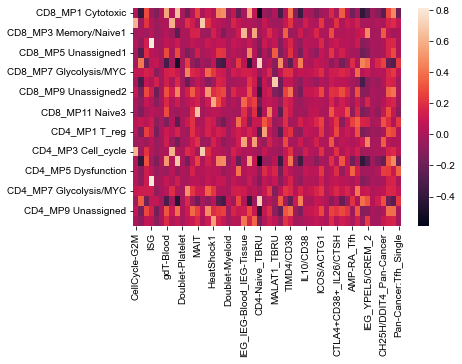

In [80]:
sns.heatmap(R)